# Applications of PostGIS Functions
In this notebook, we will look at OSM and GADM data and perform PostGIS function to perform basic exploratory analysis

In [218]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We first establish a connection to our database

In [200]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2022", 
                 password="g5!V%T1Vmd", 
                 host="192.168.212.99", 
                 port=32771)

In [201]:
# Check the available schema in our database:
pd.read_sql('''
SELECT nspname
FROM pg_catalog.pg_namespace
''', conn)

,nspname
0,pg_toast
1,pg_temp_1
2,pg_toast_temp_1
3,pg_catalog
4,information_schema
5,topology
6,public
7,gadm
8,ph_20200501
9,govt


In [202]:
pd.read_sql('''
SELECT *
FROM information_schema.schemata
''', conn)

,catalog_name,schema_name,schema_owner,default_character_set_catalog,default_character_set_schema,default_character_set_name,sql_path
0,postgis,pg_catalog,postgres,None,None,None,None
1,postgis,information_schema,postgres,None,None,None,None
2,postgis,public,postgres,None,None,None,None
3,postgis,gadm,postgres,None,None,None,None


We will be using two schemas:
1. Public : contains OSM data
2. GADM : contains GADM data

In [203]:
#Check the contents of the public schema
pd.read_sql('''
SELECT * FROM information_schema.tables 
WHERE table_schema = 'public'
''',conn)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,postgis,public,spatial_ref_sys,BASE TABLE,None,None,None,None,None,YES,NO,None
1,postgis,public,ph_line,BASE TABLE,None,None,None,None,None,YES,NO,None
2,postgis,public,pop_census_place,BASE TABLE,None,None,None,None,None,YES,NO,None
3,postgis,public,geography_columns,VIEW,None,None,None,None,None,NO,NO,None
4,postgis,public,ph_roads,BASE TABLE,None,None,None,None,None,YES,NO,None
5,postgis,public,au_point,BASE TABLE,None,None,None,None,None,YES,NO,None
6,postgis,public,geometry_columns,VIEW,None,None,None,None,None,YES,NO,None
7,postgis,public,ph_polygon,BASE TABLE,None,None,None,None,None,YES,NO,None
8,postgis,public,ph_point,BASE TABLE,None,None,None,None,None,YES,NO,None
9,postgis,public,au_roads,BASE TABLE,None,None,None,None,None,YES,NO,None


In [204]:
#Check the contents of the GADM schema
pd.read_sql('''
SELECT * FROM information_schema.tables 
WHERE table_schema = 'gadm'
''',conn)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,postgis,gadm,adm0,BASE TABLE,None,None,None,None,None,YES,NO,None
1,postgis,gadm,adm1,BASE TABLE,None,None,None,None,None,YES,NO,None
2,postgis,gadm,adm4,BASE TABLE,None,None,None,None,None,YES,NO,None
3,postgis,gadm,adm3,BASE TABLE,None,None,None,None,None,YES,NO,None
4,postgis,gadm,adm5,BASE TABLE,None,None,None,None,None,YES,NO,None
5,postgis,gadm,ph_brgy,BASE TABLE,None,None,None,None,None,YES,NO,None
6,postgis,gadm,ph_hum,BASE TABLE,None,None,None,None,None,YES,NO,None
7,postgis,gadm,adm2,BASE TABLE,None,None,None,None,None,YES,NO,None
8,postgis,gadm,ph,BASE TABLE,None,None,None,None,None,YES,NO,None
9,postgis,gadm,au,BASE TABLE,None,None,None,None,None,YES,NO,None


## 1. Reading OSM Points

In [205]:
pd.set_option('display.max_columns',200)

In [206]:
#Check the contents of ph_points
df = pd.read_sql('''
SELECT *
FROM ph_point
LIMIT 100
''',conn)
df

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,barrier,bicycle,brand,bridge,boundary,building,capital,construction,covered,culvert,cutting,denomination,disused,ele,embankment,foot,generator:source,harbour,highway,historic,horse,intermittent,junction,landuse,layer,leisure,lock,man_made,military,motorcar,name,natural,office,oneway,operator,place,population,power,power_source,public_transport,railway,ref,religion,route,service,shop,sport,surface,toll,tourism,tower:type,tunnel,water,waterway,wetland,width,wood,z_order,way
0,4332833465,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,slipway,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0101000020E6100000EBA7FFAC790C5C4030963325A3B0...
1,5127953795,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Đá Tây,None,None,None,None,village,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0101000020E610000087527B116D105C4055FC3ACB87BB...
2,4332833991,None,None,None,None,None,None,None,ferry_terminal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0101000020E610000022CC481861105C40F863A428E1BB...
3,2645876983,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,lighthouse,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0101000020E61000007E1EA33C73105C40505A136635BC...
4,2645876976,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,West Reef,None,None,None,None,island,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0101000020E6100000060BCCAF8B105C40EFE192E34EBD...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4886991329,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,tower,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,communication,None,None,None,None,None,None,None,0101000020E61000003A5563AEB1EF5D409D966945E510...
96,332020043,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,328,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Simunul Peak,peak,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0101000020E6100000A47213B5B4EF5D40EFC0A5081511...
97,4886991379,None,None,None,None,None,None,None,shelter,None,None,None,None,None,None,None,None,None,None,None,None,None,None,313,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

In [207]:
df.columns

Index(['osm_id', 'access', 'addr:housename', 'addr:housenumber',
       'addr:interpolation', 'admin_level', 'aerialway', 'aeroway', 'amenity',
       'area', 'barrier', 'bicycle', 'brand', 'bridge', 'boundary', 'building',
       'capital', 'construction', 'covered', 'culvert', 'cutting',
       'denomination', 'disused', 'ele', 'embankment', 'foot',
       'generator:source', 'harbour', 'highway', 'historic', 'horse',
       'intermittent', 'junction', 'landuse', 'layer', 'leisure', 'lock',
       'man_made', 'military', 'motorcar', 'name', 'natural', 'office',
       'oneway', 'operator', 'place', 'population', 'power', 'power_source',
       'public_transport', 'railway', 'ref', 'religion', 'route', 'service',
       'shop', 'sport', 'surface', 'toll', 'tourism', 'tower:type', 'tunnel',
       'water', 'waterway', 'wetland', 'width', 'wood', 'z_order', 'way'],
      dtype='object')

#### Class Exercise
- What are the top 10 amenity types in the ph_point table?
- What are the top 10 most frequent "brand" in the table?

In [208]:
# Top 10 amenity types
pd.read_sql('''
SELECT amenity, count(*)
FROM ph_point AS p
WHERE p.amenity IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
''',conn)

,amenity,count
0,restaurant,8869
1,school,5853
2,bank,5369
3,fast_food,5249
4,place_of_worship,4652
5,fuel,3799
6,pharmacy,2956
7,cafe,2171
8,parking,1661
9,bar,1177


In [209]:
# Top 10 brands
pd.read_sql('''
SELECT brand, count(*)
FROM ph_point p
WHERE p.brand IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
LIMIT 15
''',conn)

,brand,count
0,Petron,607
1,Shell,341
2,Caltex,267
3,Western Union,175
4,Flying V,93
5,SeaOil,92
6,Total,82
7,Phoenix,73
8,Jetti,20
9,Gas Station,18


In [210]:
# Top 10 brands
pd.read_sql('''
SELECT name, count(*)
FROM ph_point p
WHERE p.name IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
''',conn)

,name,count
0,Landslide,2621
1,7-Eleven,1234
2,Petron,750
3,Jollibee,619
4,Mercury Drug,547
5,BDO,520
6,BPI,410
7,Shell,389
8,Caltex,318
9,Chowking,302


#### Exercise (Choose at least 1 to answer)
- Find out which "bars" violate the rule that they cannot be within 500 units from a "school"
- What restaurant is the most accessible to banks in terms of distance?
- On average, how far should I need to walk from an atm machine to the nearest toilet?

In [211]:
import geopandas as gpd

In [212]:
df = pd.read_sql('''
SELECT p2.name, st_transform(p1.way,3123) as geom
FROM public.ph_point AS p1
JOIN public.ph_point AS p2 ON ST_dwithin(st_transform(p1.way,3123),st_transform(p2.way,3123),500)
WHERE p1.amenity = 'school' AND p2.amenity = 'bar'
''',conn)

In [213]:
df

,name,geom
0,Myras Karaoke Bar,0101000020330C0000180D563EBE2BFA4001286B6818DB...
1,"History Karaoke Bar & Cocktail Lounge, Inc.",0101000020330C0000EE24D31EADE12241C24DE9832E53...
2,None,0101000020330C0000FF2ADD93EBE22641D46F7F9A90D7...
3,None,0101000020330C00000EBC81CE8FE326417E128285DDD7...
4,Resto Seb,0101000020330C0000CAE06C1A196B2741FF482DD6BC75...
...,...,...
1226,Raul Best Barbecue,0101000020330C00004087D62CE8572B414CF95363D321...
1227,888 Grill and cafe,0101000020330C0000D3110BC1972B29411B7C573D74EA...
1228,888 Grill and cafe,0101000020330C0000D0802475DA3229415C8ABAB288EA...
1229,Chaze Restogrill Bar,0101000020330C00001D0FE348CA5A284111E67E3D9735...


In [214]:
df = gpd.read_postgis('''
SELECT p2.name, st_transform(p1.way,3123) as geom
FROM public.ph_point AS p1
JOIN public.ph_point AS p2 ON ST_dwithin(st_transform(p1.way,3123),st_transform(p2.way,3123),500)
WHERE p1.amenity = 'school' AND p2.amenity = 'bar'
''',con = conn, geom_col = 'geom')

In [215]:
df

,name,geom
0,Myras Karaoke Bar,POINT (107195.890 945548.204)
1,"History Karaoke Bar & Cocktail Lounge, Inc.",POINT (618710.560 764311.258)
2,None,POINT (749941.789 846792.302)
3,None,POINT (750023.903 846830.761)
4,Resto Seb,POINT (767372.552 867038.418)
...,...,...
1226,Raul Best Barbecue,POINT (895988.088 1384915.388)
1227,888 Grill and cafe,POINT (824779.877 1436276.240)
1228,888 Grill and cafe,POINT (825709.229 1436296.698)
1229,Chaze Restogrill Bar,POINT (798053.142 1455511.240)


<AxesSubplot:>

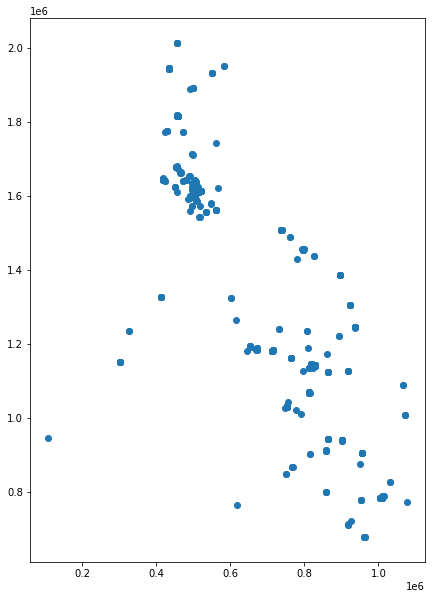

In [216]:
df.plot()

<b>what restaurant is the most accessible to banks in terms of distance?</b>

In [19]:
# what restaurant is the most accessible to banks in terms of distance?
df = pd.read_sql('''
    SELECT DISTINCT(p2.name),
    ST_distance(st_transform(p1.way, 3123), st_transform(p2.way, 3123)) as D
    FROM ph_point AS p1, ph_point AS p2
    WHERE p1.amenity = 'bank' AND p2.amenity = 'restaurant'
    ORDER BY D
    LIMIT 1
    ''', conn)
df

,name,d
0,Yellow Cab,2.482114


## 2. Reading OSM Lines and Polygons

In [20]:
# Check the contents of ph_line and ph_polygon
dfl = pd.read_sql('''
SELECT *
FROM ph_line
LIMIT 100
''',conn)
dfl

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,barrier,bicycle,brand,bridge,boundary,building,construction,covered,culvert,cutting,denomination,disused,embankment,foot,generator:source,harbour,highway,historic,horse,intermittent,junction,landuse,layer,leisure,lock,man_made,military,motorcar,name,natural,office,oneway,operator,place,population,power,power_source,public_transport,railway,ref,religion,route,service,shop,sport,surface,toll,tourism,tower:type,tracktype,tunnel,water,waterway,wetland,width,wood,z_order,way_area,way
0,187896430,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,trunk,None,None,None,None,None,None,None,None,None,None,None,EDSA,None,None,yes,None,None,None,None,None,None,None,1;AH26,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,38,None,0102000020E61000001500000026C632FD12405E407A20...
1,448161502,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,steps,None,None,None,None,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,210,None,0102000020E6100000030000002305604DAF405E409993...
2,114100860,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,trunk,None,None,None,None,None,None,None,None,None,None,None,EDSA,None,None,yes,None,None,None,None,None,None,None,1;AH26,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,38,None,0102000020E61000001E00000033BD699F33415E40416C...
3,11624534,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,yes,None,None,footway,None,None,None,None,None,2,None,None,None,None,None,Kaingin Footbridge,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,310,None,0102000020E610000003000000FEC34C91B2405E400732...
4,448161501,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,steps,None,None,None,None,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,210,None,0102000020E61000000300000099B624ACB2405E408767...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,560083845,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,service,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,15,None,0102000020E610000002000000FCB1FFF0A9405E402D4F...
96,560083846,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,residential,None,None,None,None,None,None,None,None,None,None,None,Macabagdal Street,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,33,None,0102000020E610000005000000FCB1FFF0A9405E402D4F...
97,448161474,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,National Grid Corporation of the Philippines,None,None,portal,None,None,None,None,None,None,None,None,None,No

In [21]:
dfl.columns

Index(['osm_id', 'access', 'addr:housename', 'addr:housenumber',
       'addr:interpolation', 'admin_level', 'aerialway', 'aeroway', 'amenity',
       'area', 'barrier', 'bicycle', 'brand', 'bridge', 'boundary', 'building',
       'construction', 'covered', 'culvert', 'cutting', 'denomination',
       'disused', 'embankment', 'foot', 'generator:source', 'harbour',
       'highway', 'historic', 'horse', 'intermittent', 'junction', 'landuse',
       'layer', 'leisure', 'lock', 'man_made', 'military', 'motorcar', 'name',
       'natural', 'office', 'oneway', 'operator', 'place', 'population',
       'power', 'power_source', 'public_transport', 'railway', 'ref',
       'religion', 'route', 'service', 'shop', 'sport', 'surface', 'toll',
       'tourism', 'tower:type', 'tracktype', 'tunnel', 'water', 'waterway',
       'wetland', 'width', 'wood', 'z_order', 'way_area', 'way'],
      dtype='object')

In [22]:
dfpl = pd.read_sql('''
SELECT *
FROM ph_polygon
LIMIT 100
''',conn)
dfpl

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,barrier,bicycle,brand,bridge,boundary,building,construction,covered,culvert,cutting,denomination,disused,embankment,foot,generator:source,harbour,highway,historic,horse,intermittent,junction,landuse,layer,leisure,lock,man_made,military,motorcar,name,natural,office,oneway,operator,place,population,power,power_source,public_transport,railway,ref,religion,route,service,shop,sport,surface,toll,tourism,tower:type,tracktype,tunnel,water,waterway,wetland,width,wood,z_order,way_area,way
0,449486560,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,3.839200e-09,0103000020E6100000010000000500000033203130615C...
1,449486404,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,5.576110e-09,0103000020E6100000010000000500000021F422C9625C...
2,449486504,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,3.488820e-09,0103000020E6100000010000000500000085FB123B645C...
3,449486679,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,4.066460e-09,0103000020E6100000010000000500000054DE33B7675C...
4,449486634,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,6.588610e-09,0103000020E6100000010000000500000040ACEDDC6A5C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,309859198,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,7.403510e-08,0103000020E61000000100000005000000702711E15F5C...
96,322222207,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,6.471510e-09,0103000020E61000000100000005000000DB42A1AF6A5C...
97,316161074,None,None,None,None,None,None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

## 3. Reading GADM data

In [23]:
# Check the contents of gadm.ph
pd.read_sql('''
SELECT *
FROM gadm.ph
LIMIT 100
''',conn)

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,None,Bayan|Munisipyo,Municipality,140101,PH.AB.BN,0106000020E610000001000000010300000001000000C7...
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,None,None,Bayan|Munisipyo,Municipality,140102,PH.AB.BL,0106000020E6100000010000000103000000010000001F...
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,None,None,Bayan|Munisipyo,Municipality,140103,PH.AB.BU,0106000020E61000000100000001030000000100000072...
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,None,None,Bayan|Munisipyo,Municipality,140104,PH.AB.BC,0106000020E6100000010000000103000000010000000F...
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,None,None,Bayan|Munisipyo,Municipality,140105,PH.AB.DG,0106000020E6100000010000000103000000010000001C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,81,PHL,Philippines,PHL.5_1,Albay,None,PHL.5.10_1,Malilipot,None,None,Bayan|Munisipyo,Municipality,50509,PH.AL.ML,0106000020E61000000200000001030000000100000084...
96,82,PHL,Philippines,PHL.5_1,Albay,None,PHL.5.11_1,Malinao,None,None,Bayan|Munisipyo,Municipality,50510,PH.AL.ML,0106000020E610000001000000010300000001000000CE...
97,83,PHL,Philippines,PHL.5_1,Albay,None,PHL.5.12_1,Manito,None,None,Bayan|Munisipyo,Municipality,50511,PH.AL.MN,0106000020E610000001000000010300000001000000F2...
98,85,PHL,Philippines,PHL.5_1,Albay,None,PHL.5.14_1,Pio Duran,None,None,Bayan|Munisipyo,Municipality,50513,PH.AL.PO,0106000020E61000000100000001030000000100000097...


In [24]:
df = gpd.read_postgis('''
SELECT *
FROM gadm.ph
''',conn)

<AxesSubplot:>

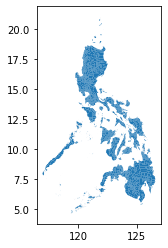

In [25]:
df.plot()

In [26]:
df = gpd.read_postgis('''
SELECT *
FROM gadm.ph
WHERE name_1 = 'Albay' AND name_2 = 'Malinao'
''',conn)

<AxesSubplot:>

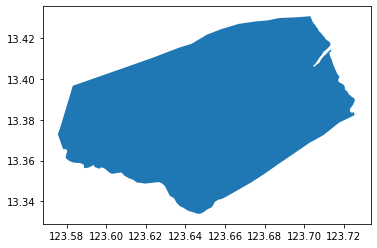

In [27]:
df.plot()

In [28]:
# What's the difference of name_0, name_1, and name_2?

#### Exercise:
- What is the top 10 most common city/municipality name?
- Which province has the most city/municipality? The least?

In [29]:
pd.read_sql('''
SELECT name_2, count(*)
FROM gadm.ph
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
''',conn)

,name_2,count
0,San Isidro,9
1,San Jose,9
2,Santa Maria,7
3,Rizal,7
4,San Juan,7
5,San Miguel,7
6,Pilar,7
7,Santa Cruz,6
8,Quezon,6
9,Carmen,6


<b>Which province has the most number of municipalities/cities?</b>

In [30]:
# Which province has the most number of municipalities/cities?
# top 10 provinces with most number of cities
df = pd.read_sql("""
SELECT name_1, count(name_2) as counts
FROM gadm.ph
GROUP BY name_1
ORDER BY counts DESC
LIMIT 10
""", conn)
df


,name_1,counts
0,Cebu,54
1,Bohol,48
2,Pangasinan,48
3,Iloilo,44
4,Leyte,43
5,Lanao del Sur,42
6,Quezon,42
7,Camarines Sur,39
8,Isabela,37
9,Maguindanao,35


## 4. Spatial Analysis using GADM

In [31]:
# What is the total area and perimeter of Makati City?
df = pd.read_sql('''
SELECT *, st_area(st_transform(g.geom,3123)), st_perimeter(st_transform(g.geom,3123))
FROM gadm.ph g
WHERE name_2 LIKE '%Makati%'
''',conn)
df

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom,st_area,st_perimeter
0,963,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.3_1,Makati City,"Makati, City of",None,Lungsod|Siyudad,City,137602,PH.MM.MK,0106000020E6100000010000000103000000010000009B...,3.174949e+07,27681.695213


In [32]:
# What is the largest city/municipality in terms of area? perimeter?
pd.read_sql('''
SELECT name_2, st_area(st_transform(g.geom,3123))
FROM gadm.ph g
ORDER BY 2 DESC
''',conn)

,name_2,st_area
0,Sablayan,2.349507e+09
1,Davao City,2.235635e+09
2,Puerto Princesa City,2.179525e+09
3,Nagtipunan,1.523349e+09
4,Zamboanga City,1.462348e+09
...,...,...
1642,Pateros,1.954985e+06
1643,Sampaloc Lake,8.772879e+05
1644,Kalibato Lake,5.400293e+05
1645,Waterbody,5.239115e+05


In [33]:
pd.read_sql('''
SELECT name_2, st_perimeter(st_transform(g.geom,3123))
FROM gadm.ph g
ORDER BY 2 DESC
''',conn)

,name_2,st_perimeter
0,Taytay,896027.164587
1,Coron,588731.661532
2,Puerto Princesa City,509509.370551
3,Culion,479856.924442
4,Zamboanga City,424608.281021
...,...,...
1642,Pateros,7392.438703
1643,Waterbody,3992.607178
1644,Sampaloc Lake,3537.255489
1645,Kalibato Lake,2957.150366


#### Exercise (Choose at least 1 to answer)
- How far is Makati City from Quezon City?
- What cities are directly connected to Makati city?
- At which city is the geographic center of Metro Manila located?
- How long is the shared perimeter of Taguig and Makati?


In [34]:
pd.read_sql('''
SELECT st_distance(st_transform(g1.geom,3123),st_transform(g2.geom,3123))
FROM gadm.ph g1
JOIN gadm.ph g2 ON TRUE
WHERE g1.name_2 = 'Makati City' AND g2.name_2 = 'Quezon City'
''',conn)

,st_distance
0,2352.966439


In [35]:
pd.read_sql('''
SELECT g2.name_2
FROM gadm.ph g1
JOIN gadm.ph g2 ON st_touches(st_transform(g1.geom,3123),st_transform(g2.geom,3123))
WHERE g1.name_2 = 'Makati City'
''',conn)

,name_2
0,Pateros
1,Mandaluyong
2,Manila
3,Pasay City
4,Pasig City
5,Taguig


In [36]:
pd.read_sql('''
SELECT st_length(st_intersection(st_transform(g1.geom,3123),st_transform(g2.geom,3123)))
FROM gadm.ph g1
JOIN gadm.ph g2 ON TRUE
WHERE g1.name_2 = 'Makati City' AND g2.name_2 = 'Taguig'
''',conn)

,st_length
0,8778.193956


## 5. Combining GADM and OSM info

In [37]:
# What are the most frequent amenities inside Makati City?
pd.read_sql('''
SELECT amenity, COUNT(*)
FROM gadm.ph g
JOIN public.ph_point p ON st_within(st_transform(p.way,3123),st_transform(g.geom,3123))
WHERE g.name_2 = 'Makati City'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
''',conn)

,amenity,count
0,None,2923
1,restaurant,678
2,bank,462
3,fast_food,246
4,cafe,187
5,bar,99
6,pharmacy,63
7,parking,51
8,school,39
9,place_of_worship,39


## Assignment

Suppose that you are the *head of branch expansion* of food chain "McDollibee" with the base of operations located here at AIM. You are tasked to create a strategy that considers the following:
1. Level of Urbanization - You want to expand to a location where the amenity density is in top 10 percentile. 
2. Market Availability and Competition - You cater to students but you prefer areas with limited competition
3. Logistics - The farther the location is from AIM, the more expensive building the branch will be.

Using the information available to you, create a report on what possible locations fit the requirements of your branch expansion strategy.

In [39]:
#Your Code and Report Here
df_urban = pd.read_sql("""
select 
    name_2, count(amenity)
from 
    gadm.ph as g
join 
    public.ph_point AS p ON st_within(st_transform(p.way, 3123), st_transform(g.geom, 3123))
where 
    g.name_1 = 'Metropolitan Manila' and p.amenity is not null
group by 
    1
order by 
    2 desc
""", conn)
df_urban

,name_2,count
0,Quezon City,3836
1,Makati City,2333
2,Manila,1863
3,Pasig City,1078
4,Parañaque,844
5,Marikina,736
6,Pasay City,711
7,Muntinlupa,666
8,Las Piñas,614
9,Mandaluyong,492


### Level of Urbanization

We focused on cities within the metropolitan manila area and saw that the most urbanized cities that belong to the 90th percentile were `Quezon City` and `Makati City`. These two cities are our best options where we can put up the new branch. However, since due to logistics constraints, it will be more costly for us to establish the branch in `Quezon City` compared to establishing it in `Makati City` where AIM is located.

In [46]:
df_urban[df_urban['count']>= df_urban['count'].quantile(0.9)]

,name_2,count
0,Quezon City,3836
1,Makati City,2333


## Market Research

In [143]:
df_schools_avoid = gpd.read_postgis('''
select 
    p1.name, st_transform(p1.way,3123) as geom
from 
    public.ph_point as p1
join 
    public.ph_point as p2 on ST_dwithin(st_transform(p1.way,3123),st_transform(p2.way,3123),400)
join 
    gadm.ph as g on st_within(st_transform(p1.way,3123),st_transform(g.geom,3123))
where 
    p1.amenity = 'school' and g.name_2 = 'Makati City' and p2.amenity = 'fast_food'
''',con = conn, geom_col = 'geom')
df_schools_avoid

,name,geom
0,Bangkal Elementary School,POINT (501043.141 1608638.116)
1,Bangkal Elementary School (Main),POINT (501109.599 1608806.079)
2,Bangkal High School (Main),POINT (501191.795 1608797.252)
3,Bangkal Elementary School,POINT (501043.141 1608638.116)
4,Bangkal Elementary School (Main),POINT (501109.599 1608806.079)
...,...,...
269,School of Mind Achivers and Reseachers of Tomo...,POINT (506621.194 1608916.275)
270,School of Mind Achivers and Reseachers of Tomo...,POINT (506621.194 1608916.275)
271,School of Mind Achivers and Reseachers of Tomo...,POINT (506621.194 1608916.275)
272,School of Mind Achivers and Reseachers of Tomo...,POINT (506621.194 1608916.275)


These are the schools in makati that have at least 1 fast food amenity within a walking distance of 400 meters near them. We have a total of `32` schools. 

In [170]:
print('Total of',df_schools_avoid.drop_duplicates(['name']).shape[0]-1, 'schools')
df_schools_avoid.drop_duplicates(['name'])

Total of 32 schools


,name,geom
0,Bangkal Elementary School,POINT (501043.141 1608638.116)
1,Bangkal Elementary School (Main),POINT (501109.599 1608806.079)
2,Bangkal High School (Main),POINT (501191.795 1608797.252)
10,Rizal City School,POINT (500713.255 1609012.218)
12,Bangkal Computer Center,POINT (500864.865 1608904.622)
14,AMA School of Medicine-Makati,POINT (501208.410 1608914.143)
15,AMA School of Medicine,POINT (501211.180 1608912.495)
16,AMACC Makati,POINT (501166.992 1608996.691)
17,Teacher Marie,POINT (500851.378 1609315.217)
33,Microcadd Institute Makati,POINT (501444.948 1609609.566)


However, if we query all of the schools in Makati, there are a total of `37` schools. This means that only `5` schools do not have a fast food amenity within a 400 meter radius around them.  

In [159]:
df_all_schools = gpd.read_postgis('''
select 
    p1.name, st_transform(p1.way,3123) as geom
from 
    public.ph_point as p1
join 
    gadm.ph as g on st_within(st_transform(p1.way,3123),st_transform(g.geom,3123))
where 
    p1.amenity = 'school' and g.name_2 = 'Makati City'
''',con = conn, geom_col = 'geom')
df_all_schools

,name,geom
0,Bangkal Elementary School,POINT (501043.141 1608638.116)
1,Philippines School of Interior Design,POINT (501603.019 1608599.863)
2,Greenhouse Training and Assesment Center Inc.,POINT (500159.645 1610684.707)
3,Rizal City School,POINT (500713.255 1609012.218)
4,Bangkal Elementary School (Main),POINT (501109.599 1608806.079)
5,Bangkal Computer Center,POINT (500864.865 1608904.622)
6,Bangkal High School (Main),POINT (501191.795 1608797.252)
7,AMA School of Medicine-Makati,POINT (501208.410 1608914.143)
8,AMA School of Medicine,POINT (501211.180 1608912.495)
9,AMACC Makati,POINT (501166.992 1608996.691)


In [176]:
all_unique_schools = df_all_schools.drop_duplicates(['name'])
all_unique_schools.shape[0]-1

37

These are the 5 schools that do not have any fast food amenity within walking distance of their location. These are the schools that the company should try to target.

In [177]:
df_potential = all_unique_schools[~all_unique_schools['name'].isin(df_schools_avoid.drop_duplicates(['name'])['name'])]
df_potential

,name,geom
1,Philippines School of Interior Design,POINT (501603.019 1608599.863)
31,Guadalupe Central Elementary School,POINT (504262.657 1610099.476)
32,Full Bright Science School,POINT (504550.908 1610271.588)
33,Pineslight School,POINT (504864.662 1610378.685)
37,South Cembo Elementary School,POINT (505228.714 1610217.283)


All the fast food amenities in makati city for plotting.

In [238]:
df_fastfood = gpd.read_postgis('''
select 
    p1.name, st_transform(p1.way,3123) as geom
from 
    public.ph_point as p1
join 
    gadm.ph as g on st_within(st_transform(p1.way,3123),st_transform(g.geom,3123))
where 
    p1.amenity = 'fast_food' and g.name_2 = 'Makati City'
''',con = conn, geom_col = 'geom')
df_fastfood

,name,geom
0,Jollibee,POINT (501160.885 1607990.212)
1,Pizza Hut Evangelista,POINT (501165.712 1608021.114)
2,McDonald's,POINT (501189.035 1607996.011)
3,Mang Inasal,POINT (501192.041 1608019.699)
4,Kowloon House,POINT (501171.239 1608103.176)
...,...,...
241,Jala,POINT (505723.328 1610769.199)
242,Joshua's Siomai etc,POINT (506235.711 1610292.797)
243,Angel's Burger,POINT (506631.313 1610269.900)
244,Fariñas Ilocano Empanada,POINT (502783.487 1611261.271)


### Recommendation

Integrating all the information that we have gathered, we can now plot the schools, the targets, AIM, and all the fast food amenities in a plot. As we can see from the plot below, the upper right quadrant clearly is the best location to set up the branch for Mcdollibee. This quadrant contains 4 out of 5 target schools and it is less dense in terms of competition. While there are less competitors in this quadrant, it can also be observed that the market there is also fewer than that of the upper left quadrant where most of the market and competition are concentrated. However, it is still profitable to establish a branch in the upper right quadrant since we can capitalize on the 4 schools that do not have a fast food amenity within walking distance. It is recommended that we establish the branch in this quadrant, specifically on the location where we can tap the 4 target schools. 

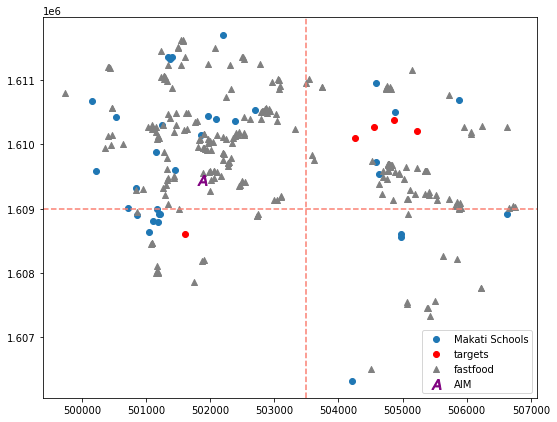

In [244]:

fig, ax = plt.subplots(figsize=(25,7))

df_schools_avoid.drop_duplicates(['name']).plot(ax=ax, label='Makati Schools')

AIM = gpd.read_postgis('''
SELECT ST_TRANSFORM(ST_SETSRID(ST_POINT(121.0187, 14.5524), 4326), 3123) as aim_loc'''
, con=conn, geom_col='aim_loc')



df_potential.plot(ax=ax, color='red', label='targets')
df_fastfood.plot(ax=ax, color='grey', label='fastfood', marker='^')
AIM.plot(color='purple', ax=ax, label='AIM', marker='$A$', markersize=100)
plt.axvline(503500, ls='--', color='salmon')
plt.axhline(y=1609000, ls='--', color='salmon')
plt.legend(loc=4)
plt.show()